In [65]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pipeline 

In [66]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [67]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [68]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [69]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [70]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

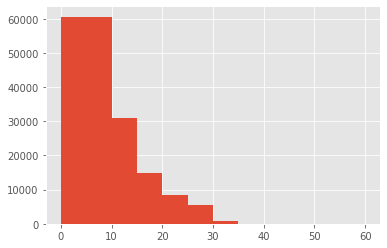

121281


In [71]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=30 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [72]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  gostei produto bonito pratico alem sofisticado...
1                    5  produto funciona perfeitamente entrega rapida ...
2                    4  entrega bem antes data prevista porem alguns c...
3                    5  comprei medo nao chegar conforme anunciado che...
4                    3  produto nao veio mostra site veio diferente co...
...                ...                                                ...
132368               1  atencao bateria drenada rapidamente dura maxim...
132369               5  potente resistente gostei entregue dentro praz...
132370               1  produto qualidade ruim devido pedi cancelament...
132371               5                bem atendido agradeco atencao todos
132372               5                      supriu totalmente necessidade

[132373 rows x 2 columns]>


In [79]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [80]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [78]:
b2wCorpusTrain.head

<bound method NDFrame.head of         overall_rating                                        review_text
48791                5  entrega data estipulada bem embalado perfeitas...
106119               3  gostei qualidade produto chegou rapido antes data
20804                5  comprei zenfone cor dourado adorei ver dourado...
15652                4  entrega dentro prazo produto excelente satisfe...
53944                1  nao posso dizer nada ainda pois nao recebi agu...
...                ...                                                ...
93910                4  notebook pra uso domestico pra estudar bom ate...
87085                5  ja cliente motorola sempre continuo surpreendendo
128026               1  produto ainda nao entregue ser entregue semana...
103515               5   otimo prazo entrega menos informava amei produto
19623                4  potes sao lindos porem achei pequenos menor tr...

[86042 rows x 2 columns]>

In [81]:
b2wCorpusValidate.head

<bound method NDFrame.head of         overall_rating                                        review_text
32891                5        produto otimo unico problema demorou chegar
100051               5  chegou rapido nao nenhum problema durante todo...
17066                1  nao comprem mega page ficaram entregar dia cas...
16711                2  infelizmente apos comprar maquina verifiquei s...
108731               4  excelente produto valei pena compra satisfeita...
...                ...                                                ...
17538                1  produto lixo arrependido qualidade pessima vei...
98328                5  maravilhoso surpreendeu expectativas chegou an...
59850                5  carrinho simples oferece prometido proposta aj...
80506                5        melhor ainda apreciar whisky gelo agua coco
66911                4  otimo livro dei presente entao nao posso falar...

[13237 rows x 2 columns]>

In [82]:
b2wCorpusTest.head

<bound method NDFrame.head of         overall_rating                                        review_text
110624               4             lindo confortavel comprei preto branco
34055                5     livro bom ainda vem otimo conteudo atualizacao
99032                5  produto bonito esposa gostou bastante so nao v...
121621               5  excelente produto recomendaria todos design se...
63428                3  vou comprar espero venha conforme foto rack na...
...                ...                                                ...
110268               1        nao funcionou nao recomendo produto ninguem
119879               1  dois dias uso botoes pararam funcionar agua sa...
103694               5  designe configuracoes j pro realmente excelent...
131932               5               bom produto entrega rapida recomendo
121958               1  boneca vendida nao estoque pessimo atendimento...

[33094 rows x 2 columns]>

In [73]:
# Treino, Validação e teste

x = b2wCorpus[['review_text']].values
y = b2wCorpus[['overall_rating']].values

print((b2wCorpus.overall_rating.value_counts()/ b2wCorpus.shape[0]).sort_index())

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
#Tokenizando
vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)

1    0.206757
2    0.063374
3    0.123250
4    0.244347
5    0.362272
Name: overall_rating, dtype: float64
42768


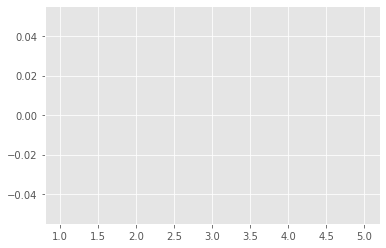

In [74]:
Labels = [(b2wCorpus.overall_rating.value_counts()/ b2wCorpus.shape[0]).sort_index() ]
plt.style.use('ggplot')
plt.hist(Labels, bins=[1,2,3,4,5])
plt.show()